In [1]:
from __future__ import print_function

import keras.backend as K
from keras.layers import Dense, Input, Activation
from keras.models import Model

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from src.fetch_mnist import preprocessed_mnist

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Useful links

# TODO

#### Preparing data

We'll use MNIST dataset. Examples are standardised according to training data.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_labels, y_test_labels = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test_labels, y_valid_labels = train_test_split(X_test, y_test_labels, test_size=0.5) 

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [3]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

y_train = ohe.fit_transform(y_train_labels.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test_labels.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid_labels.reshape(-1, 1)).toarray()

## Logistic regression with softmax using `module` API

`keras.layers` contains `Layers` - abstractions that behave like neural network layers, and can be used as functions of tensors (note, for example usage of `Dense` layer), or appended in sequential models.

`keras.models` contains `Model` class - it provides high-level functionalities a'la `scikit-learn` estimators. `Model`s wrap Keras tensors. 

Below is an example of simple *Model* that performs logistic regression (it uses minibatch gradient descent for optimization).

In [4]:
input_shape = (X_train.shape[1],)
n_classes = y_train.shape[1]

softmax_input =  Input(shape=input_shape)
softmax_intermediate = Dense(n_classes)(softmax_input)
softmax_output = Activation('softmax')(softmax_intermediate) 

logistic_classifier = Model(inputs=[softmax_input], outputs=[softmax_output])

logistic_classifier.compile(optimizer='adam', loss=['categorical_crossentropy'])

The following cell contains code that can be passed to our Module's `fit` method. It is used to save per-batch metric (here accuracy is used).

#### Training

In [5]:
%%time

fit_history = logistic_classifier.fit(
  X_train, y_train,
  validation_data=(X_valid, y_valid),
  epochs=100,
  batch_size=128
)

Train on 56000 samples, validate on 7000 samples
Epoch 1/100
56000/56000 [==============================] - 2s 43us/step - loss: 0.5420 - val_loss: 0.3447
Epoch 2/100
56000/56000 [==============================] - 2s 39us/step - loss: 0.3213 - val_loss: 0.3107
Epoch 3/100
56000/56000 [==============================] - 2s 35us/step - loss: 0.2964 - val_loss: 0.3003
Epoch 4/100
56000/56000 [==============================] - 2s 33us/step - loss: 0.2833 - val_loss: 0.2997
Epoch 5/100
56000/56000 [==============================] - 2s 34us/step - loss: 0.2753 - val_loss: 0.2944
Epoch 6/100
56000/56000 [==============================] - 2s 33us/step - loss: 0.2687 - val_loss: 0.2955
Epoch 7/100
56000/56000 [==============================] - 2s 32us/step - loss: 0.2649 - val_loss: 0.2946
Epoch 8/100
56000/56000 [==============================] - 2s 33us/step - loss: 0.2614 - val_loss: 0.2950
Epoch 9/100
56000/56000 [==============================] - 2s 33us/step - loss: 0.2588 - val_loss: 0.29

56000/56000 [==============================] - 2s 34us/step - loss: 0.2257 - val_loss: 0.3343
Epoch 78/100
56000/56000 [==============================] - 2s 33us/step - loss: 0.2254 - val_loss: 0.3351
Epoch 79/100
56000/56000 [==============================] - 2s 34us/step - loss: 0.2254 - val_loss: 0.3366
Epoch 80/100
56000/56000 [==============================] - 2s 37us/step - loss: 0.2258 - val_loss: 0.3355
Epoch 81/100
56000/56000 [==============================] - 2s 33us/step - loss: 0.2245 - val_loss: 0.3373
Epoch 82/100
56000/56000 [==============================] - 2s 33us/step - loss: 0.2248 - val_loss: 0.3355
Epoch 83/100
56000/56000 [==============================] - 2s 33us/step - loss: 0.2248 - val_loss: 0.3367
Epoch 84/100
56000/56000 [==============================] - 2s 34us/step - loss: 0.2247 - val_loss: 0.3421
Epoch 85/100
56000/56000 [==============================] - 2s 34us/step - loss: 0.2251 - val_loss: 0.3370
Epoch 86/100
56000/56000 [========================

In [9]:
y_test_pred_proba = logistic_classifier.predict(X_test)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

In [14]:
from sklearn.metrics import accuracy_score

def evaluate_classifier(clf, round_to=3):
  datasets = [X_train, X_valid, X_test]
  label_sets = [y_train_labels, y_valid_labels, y_test_labels]
  for (set_label, X, labels) in zip(['train', 'validation', 'test'], datasets, label_sets):
    y_pred_proba = clf.predict(X)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(labels, y_pred)

    print(
      'accuracy on {} set:\n{}'.format(
        set_label,
        round(accuracy, round_to)))

In [15]:
evaluate_classifier(logistic_classifier)

accuracy on train set:
0.942
accuracy on validation set:
0.918
accuracy on test set:
0.917


## Validation vs training loss 

In [19]:
def plot_train_vs_validation_loss(history, offset=0):
  train_loss = history.history['loss']
  eval_loss = history.history['val_loss']
  l = len(train_loss)
  rng = np.arange(start=offset, stop=l)
  
  plt.plot(rng, train_loss[offset:], label='train')
  plt.plot(rng, eval_loss[offset:], label='validation')
  plt.legend()
  plt.show()

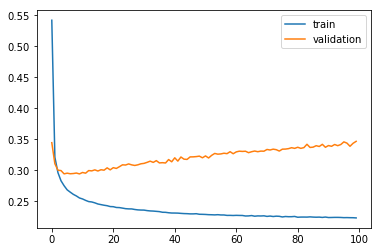

In [20]:
plot_train_vs_validation_loss(fit_history)

In [ ]:
plot_train_vs_validation_loss(mlp_train_loss, mlp_eval_loss, offset=10)

## Accuracy

In [ ]:
evaluate_classifier(mlp)

## Different optimizers/hyperparameters

In [ ]:
customized_mlp = mod.Module(symbol=mlp_out(num_hidden))

customized_mlp.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
customized_mlp.init_params(initializer=mx.init.Xavier(magnitude=2.))

In [ ]:
customized_mlp_train_log_list = []
customized_mlp_eval_log_list = []

%time customized_mlp.fit(\
  train_iter,\
  eval_data=valid_iter,\
  optimizer='adam',\
  optimizer_params={'learning_rate': 0.001, 'wd': 1e-3},\
  eval_metric='ce',\
  batch_end_callback=log_to_list(customized_mlp_train_log_list),\
  eval_batch_end_callback=log_to_list(customized_mlp_eval_log_list, data_type='Valid'),\
  num_epoch=50)

In [ ]:
customized_mlp_train_loss = [msg[1][4] for msg in customized_mlp_train_log_list]
customized_mlp_eval_loss = [msg[1][4] for msg in customized_mlp_eval_log_list]

In [ ]:
plot_train_vs_validation_loss(customized_mlp_train_loss, customized_mlp_eval_loss)
evaluate_classifier(customized_mlp)